In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, roc_auc_score
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder
import warnings
import gc
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
from sklearn import metrics
from functools import cmp_to_key
import logging
import xgboost as xgb

logging.basicConfig(filename='log.txt',level=logging.DEBUG, format='%(asctime)s %(message)s')

plt.style.use('seaborn')
sns.set(font_scale=1)
pd.set_option('display.max_columns', 500)
plt.subplots(figsize=(15,10))

%matplotlib inline

In [2]:
DATA_DIR = '/home/ryan/cs/datasets/microsoft'

In [3]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

In [4]:
%time train = pd.read_csv(join(DATA_DIR, 'train.csv'), dtype=dtypes)
%time test = pd.read_csv(join(DATA_DIR, 'test.csv'), dtype=dtypes)

CPU times: user 1min 31s, sys: 2.2 s, total: 1min 33s
Wall time: 1min 33s
CPU times: user 1min 23s, sys: 1.6 s, total: 1min 24s
Wall time: 1min 24s


In [5]:
labels = train['HasDetections']

if 5244810 in train.index:
    train.loc[5244810,'AvSigVersion'] = '1.273.1144.0'
    train['AvSigVersion'].cat.remove_categories('1.2&#x17;3.1144.0',inplace=True)

In [6]:
def condense_feature(df, col, category_map, fill_with=None):
    feature = df[col]
    reverse_map = {}
    default_val = None
    categories = feature.unique()
    categories = categories[~pd.isnull(categories)]
    
    for k, v_arr in category_map.items():
        if len(v_arr) != 0:
            for v in v_arr:       
                reverse_map[v] = k
                index = np.argwhere(categories==v)
                categories = np.delete(categories, index)         
        else:
            default_val = k
            
    for v in categories:
        reverse_map[v] = default_val
        
    condensed = df[col].map(reverse_map)
    if fill_with:
        condensed = condensed.fillna(fill_with)
    else:
        condensed = condensed.fillna(default_val)
    
    return condensed

def generate_count_feature(df, col, counts=None):
    if counts is None:
        groups = df.groupby(col)
        counts = groups.size()
    count_feature = df[col].map(counts)
    
    return count_feature, counts

def group_battery(x):
    x = x.lower()
    if ('li' in x) or ('ion' in x):
        return 1
    else:
        return 0
    
def generate_freq_feature(df, col, on='HasDetections', frequencies=None):
#     print(frequencies)
    if frequencies is None:
        groups = df.groupby(col)
        sizes = groups.size()
        sums = groups.sum()[on]
        frequencies = sums/sizes
    freq_feature = df[col].map(frequencies)
    
    return freq_feature, frequencies

def generate_version_mapping(df, col, num_splits=4, fill_val='0.0.0.0'):
    feature = df[col].astype(str)
    feature.fillna(fill_val)
    versions = feature.unique()
    
    def version_compare(x, y):
        x_splits = x.split('.')
        y_splits = y.split('.')
        for x_val, y_val in zip(x_splits, y_splits):
            try:
                int_x = int(x_val)
            except:
                int_x = 0
            try:
                int_y = int(y_val)
            except:
                int_y = 0
            if int_x > int_y:
                return 1
            elif int_x < int_y:
                return -1
        return 0

    sorted_versions = sorted(versions, key=cmp_to_key(version_compare))
    mapping = {}
    for i, v in enumerate(sorted_versions):
        mapping[v] = i
        
    return feature.map(mapping)

def generate_split_version(df, col, num_splits=4):
    feature = df[col].astype(str)
    sv = pd.DataFrame()
    for i in range(num_splits):
        sv[col + '_' + str(i)] = feature.apply(lambda x: x.split('.')[i]).astype(int)
        
    return sv

def trim(raw_tr, raw_te, col, fill='new', factor=4):

#     le = LabelEncoder().fit(np.unique(raw_tr[col].astype(str).unique().tolist()+raw_te[col].astype(str).unique().tolist()))
    agg_tr = raw_tr.groupby(col).size().to_frame('tr_counts').reset_index()
    agg_te = raw_te.groupby(col).size().to_frame('te_counts').reset_index()
    agg = pd.merge(agg_tr, agg_te, on=col, how='outer')
    agg = agg[agg['tr_counts'] > 1000].reset_index(drop=True)
    
    agg['total_counts'] = agg['tr_counts'] + agg['te_counts']
    agg = agg[(agg['tr_counts'] / agg['total_counts'] > (1.0/factor)) & (agg['tr_counts'] / agg['total_counts'] < ((factor-1.0)/factor))]

    agg[col+'_copy'] = agg[col]
    
    trim_tr = pd.merge(raw_tr[[col]], agg[[col, col+'_copy']], on=col, how='left')[col+'_copy']
    trim_te = pd.merge(raw_te[[col]], agg[[col, col+'_copy']], on=col, how='left')[col+'_copy']
    
    return trim_tr, trim_te

def trim_ordinal(raw_tr, raw_te, col, fill='new', factor=4):
    #     le = LabelEncoder().fit(np.unique(raw_tr[col].astype(str).unique().tolist()+raw_te[col].astype(str).unique().tolist()))
    agg_tr = raw_tr.groupby(col).size().to_frame('tr_counts').reset_index()
    agg_te = raw_te.groupby(col).size().to_frame('te_counts').reset_index()
    agg = pd.merge(agg_tr, agg_te, on=col, how='outer')
    agg = agg[agg['tr_counts'] > 1000].reset_index(drop=True)
    
    agg['total_counts'] = agg['tr_counts'] + agg['te_counts']
    agg = agg[(agg['tr_counts'] / agg['total_counts'] > (1.0/factor)) & (agg['tr_counts'] / agg['total_counts'] < ((factor-1.0)/factor))]

    agg[col+'_copy'] = agg[col]
    
    trim_tr = pd.merge(raw_tr[[col]], agg[[col, col+'_copy']], on=col, how='left')[col+'_copy']
    trim_te = pd.merge(raw_te[[col]], agg[[col, col+'_copy']], on=col, how='left')[col+'_copy']
    
    return trim_tr, trim_te
    

    

In [7]:
def generate_count_df(df, cols, counts_map={}):
    count_df = pd.DataFrame()
    for col in cols:
        if col in counts_map:
            count_df[col + 'Counts'], _ = generate_count_feature(df, col, counts=counts_map[col])
        else:
            count_df[col + 'Counts'], counts_map[col] = generate_count_feature(df, col)
        
    return count_df, counts_map
        
def generate_freq_df(df, cols, freqs_map={}):
    freq_df = pd.DataFrame()
    for col in cols:
        if col in freqs_map:
            freq_df[col + 'Freqs'], _ = generate_freq_feature(df, col, frequencies=freqs_map[col])
        else:
            freq_df[col + 'Freqs'],  freqs_map[col] =  generate_freq_feature(df, col)
            
    return freq_df, freqs_map

def generate_category_df(df, cols):
    cat_df = pd.DataFrame()
    for col in cols:
        cat_df[col+'Cat'] = df[col].astype('category')
        
    return cat_df
        
def generate_boolean_df(df, cols):
    bool_df = pd.DataFrame()
    for col in cols:
        bool_df[col+'Bool'] = df[col].astype(np.bool)
        
    return bool_df
        
def generate_gb_df(df, cols):
    gb_df = pd.DataFrame()
    for col in cols:
        gb_df[col+'GB'] = df[col].fillna(df[col].median()).apply(lambda x: int(x/1000))
        
    return gb_df

In [8]:
def feature_engineer(df, frequencies_map={}, counts_map={}):

    # mine
    fe = pd.DataFrame()
    
    
    fe['MoreThanOneAV'] = condense_feature(df, 'AVProductsInstalled', {0: [0.0, 1.0], 1: []}, fill_with=0).astype(np.int8)
    
    fe['AVProductsEnabled'] = df['AVProductsEnabled'].fillna(0.0).astype(np.int8)

    
    sku_feature = condense_feature(df, 'SkuEdition', {'Home': ['Home'], 'Pro': ['Pro'], 'SkuEtc':[]})
    fe['SkuCondensed'] = sku_feature.astype('category')
    
    fe['IsProtected'] = df['IsProtected'].astype(np.bool)
    
    fe['SmartScreen'] = condense_feature(df, 'SmartScreen', 
                                            {True: ['RequireAdmin', 'On', 'Warn', 'on', 'Enabled', 'warn', 'Block', 'Prompt', 'Promp', 'requireadmin', 'prompt', 'requireAdmin'], 
                                             False: []}).astype(np.bool)
    
    
    
    fe['CountryIdentifier'] = df['CountryIdentifier'].astype('category')
    
    fe['EngineVersionMapped'] = generate_version_mapping(df, 'EngineVersion')
    fe = fe.join(generate_split_version(df, 'EngineVersion'))
    
    fe['AppVersionMapped'] = generate_version_mapping(df, 'AppVersion')
    fe = fe.join(generate_split_version(df, 'AppVersion'))
    
    fe['IeVerIdentifier'] = df['IeVerIdentifier'].fillna(0.0).astype(np.int16)
    
    fe['ProcessorCoreCount'] = df['Census_ProcessorCoreCount'].fillna(4.0).astype(np.int8)
    
    fe['Census_ProcessorModelIdentifier'] = df['Census_ProcessorModelIdentifier'].fillna(0.0).astype(np.int16)
    
    fe['Census_InternalPrimaryDiagonalDisplaySizeInInches'] = df['Census_InternalPrimaryDiagonalDisplaySizeInInches']
    
    fe['BatteryType'] = df['Census_InternalBatteryType'].apply(group_battery)
    
    fe['BatteryNumberOfCharges'] = df['Census_InternalBatteryNumberOfCharges'].fillna(df['Census_InternalBatteryNumberOfCharges'].median()).astype(np.int8)
    
    fe['AvSigVersionMapped'] = generate_version_mapping(df, 'AvSigVersion')
    fe = fe.join(generate_split_version(df, 'AvSigVersion'))
    
    count_cols = ['Platform', 'EngineVersion', 'AppVersion', 'AvSigVersion', 'AVProductStatesIdentifier',
                  'CountryIdentifier', 'Census_OSVersion', 'CityIdentifier', 'OrganizationIdentifier', 'Processor',
                  'IeVerIdentifier', 'Census_MDC2FormFactor', 'OsBuild', 'Census_ChassisTypeName', 'Census_PowerPlatformRoleName',
                   'Census_OSBranch', 'Census_OSBuildNumber', 'Census_OSBuildRevision',
                  'Census_OSEdition', 'Census_OSInstallTypeName', 'Census_ActivationChannel',
                  'Census_FirmwareVersionIdentifier', 'Census_IsTouchEnabled', 'Census_OSUILocaleIdentifier']
    
    freq_cols = ['OrganizationIdentifier', 'CountryIdentifier', 'IeVerIdentifier', 
                 'Census_ActivationChannel', 'Census_FirmwareManufacturerIdentifier', 'Census_OSUILocaleIdentifier']
    
    category_cols = ['AVProductsInstalled','LocaleEnglishNameIdentifier', 'Platform', 'Processor', 'OsBuild', 'OsSuite',
                     'OsPlatformSubRelease', 'IeVerIdentifier', 'Census_MDC2FormFactor', 
                     'Census_ProcessorCoreCount', 'Census_ProcessorManufacturerIdentifier',
                     'Census_PrimaryDiskTypeName', 'Census_ChassisTypeName', 'Census_PowerPlatformRoleName',
                     'Census_OSBranch', 'Census_OSInstallTypeName',
                     'Census_OSWUAutoUpdateOptionsName', 'Census_ActivationChannel', 'Census_FlightRing',
                     'Wdft_RegionIdentifier']
    
    gb_cols = ['Census_PrimaryDiskTotalCapacity', 'Census_SystemVolumeTotalCapacity', 'Census_TotalPhysicalRAM']
    
    boolean_cols = ['IsProtected', 'SMode', 'Firewall', 
                    'Census_HasOpticalDiskDrive', 'Census_GenuineStateName', 'Census_IsSecureBootEnabled', 
                    'Census_IsTouchEnabled', 'Census_IsPenCapable', 'Census_IsAlwaysOnAlwaysConnectedCapable',
                    'Wdft_IsGamer']
    
    
    
    count_df, counts_map = generate_count_df(df, count_cols, counts_map=counts_map)

    freq_df, frequencies_map = generate_freq_df(df, freq_cols, freqs_map=frequencies_map)
    
    fe = fe.join(count_df)

    fe = fe.join(freq_df)
    fe = fe.join(generate_category_df(df, category_cols))
    fe = fe.join(generate_gb_df(df, gb_cols))
    fe = fe.join(generate_boolean_df(df, boolean_cols))
    
    # importance from lgb_kernel
    
    fe['OSVerOrdinal'] = generate_version_mapping(df, 'Census_OSVersion')
    fe['CountryIdentifier'] = df['CountryIdentifier']
    
#     ce_hash = ce.HashingEncoder(cols=['GeoNameIdentifier'])
#     ce_hash.fit(df, labels)
#     new_dat = ce_hash.transform(df)
#     fe = fe.join(new_dat)

    # important feature
    fe['GeoName'] = df['GeoNameIdentifier'].astype('category')
    
    fe['OSBuildRevision'] = df['Census_OSBuildRevision'].astype('category')
    fe['OSBuildLab'] = df['OsBuildLab'].astype('category')
    
    fe['FirmwareManufacturer'] = df['Census_FirmwareManufacturerIdentifier'].astype('category')
    fe['AppVersion'] = df['AppVersion']
    fe['AVProductStatesIdentifier'] = df['AVProductStatesIdentifier'].astype('category')
    
    fe['OSVersion_0'] = df['Census_OSVersion'].apply(lambda x: x.split('.')[0]).astype('category')
    fe['OSVersion_1'] = df['Census_OSVersion'].apply(lambda x: x.split('.')[1]).astype('category')
    fe['OSVersion_2'] = df['Census_OSVersion'].apply(lambda x: x.split('.')[2]).astype('category')
    fe['OSVersion_3'] = df['Census_OSVersion'].apply(lambda x: x.split('.')[3]).astype('category')
    fe['AvSigVersion_1'] = df['AvSigVersion'].apply(lambda x: x.split('.')[1]).astype('category')
    fe['EngineVersion'] = df['EngineVersion'].astype('category')
    fe['Census_OSInstallTypeName'] = df['Census_OSInstallTypeName'].astype('category')
    
    
    
    
    
    return fe, frequencies_map, counts_map

In [9]:
columns_to_trim = train.columns[1:-1]

In [14]:
train.columns

Index(['MachineIdentifier', 'ProductName', 'EngineVersion', 'AppVersion',
       'AvSigVersion', 'IsBeta', 'RtpStateBitfield', 'IsSxsPassiveMode',
       'DefaultBrowsersIdentifier', 'AVProductStatesIdentifier',
       'AVProductsInstalled', 'AVProductsEnabled', 'HasTpm',
       'CountryIdentifier', 'CityIdentifier', 'OrganizationIdentifier',
       'GeoNameIdentifier', 'LocaleEnglishNameIdentifier', 'Platform',
       'Processor', 'OsVer', 'OsBuild', 'OsSuite', 'OsPlatformSubRelease',
       'OsBuildLab', 'SkuEdition', 'IsProtected', 'AutoSampleOptIn', 'PuaMode',
       'SMode', 'IeVerIdentifier', 'SmartScreen', 'Firewall', 'UacLuaenable',
       'Census_MDC2FormFactor', 'Census_DeviceFamily',
       'Census_OEMNameIdentifier', 'Census_OEMModelIdentifier',
       'Census_ProcessorCoreCount', 'Census_ProcessorManufacturerIdentifier',
       'Census_ProcessorModelIdentifier', 'Census_ProcessorClass',
       'Census_PrimaryDiskTotalCapacity', 'Census_PrimaryDiskTypeName',
       'Census_

In [15]:
def trim_all(df_train, df_test):
    fe_train = pd.DataFrame()
    fe_test = pd.DataFrame()
    for col in columns_to_trim:
        if col != 'AvSigVersion':
            fe_train[col], fe_test[col] = trim(df_train, df_test, col)
        else:
            fe_train[col] = df_train[col]
            fe_test[col] = df_test[col]
    return fe_train, fe_test

In [16]:
fe_train, fe_test = trim_all(train, test)

In [27]:
fe_train.head()

,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,AvSig2
0,win8defender,NaN,NaN,1.273.1735.0,0.0,7.0,0,NaN,53447.0,1.0,1.0,1,29.0,128035.0,18.0,35.0,-85.0,windows10,NaN,10.0.0.0,17134.0,256.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0.0,NaN,NaN,137.0,NaN,1.0,1.0,Desktop,Windows.Desktop,2668.0,NaN,4.0,5.0,2340.0,NaN,476940.0,HDD,299451.0,0,4096.0,Desktop,18.906250,1440.0,900.0,Desktop,NaN,4.294967e+09,NaN,amd64,rs4_release,17134.0,NaN,Professional,PROFESSIONAL,UUPUpgrade,26.0,119.0,UNKNOWN,0,IS_GENUINE,Retail,NaN,0.0,Retail,NaN,628.0,NaN,0,NaN,0.0,0,0,0.0,0.0,10.0,273
1,win8defender,1.1.14600.4,4.13.17134.1,1.263.48.0,0.0,7.0,0,NaN,53447.0,1.0,1.0,1,93.0,1482.0,18.0,119.0,64.0,windows10,NaN,10.0.0.0,17134.0,256.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0.0,NaN,NaN,137.0,NaN,1.0,1.0,Notebook,Windows.Desktop,2668.0,NaN,4.0,5.0,NaN,NaN,476940.0,HDD,102385.0,0,4096.0,Notebook,13.898438,1366.0,768.0,Mobile,NaN,1.000000e+00,10.0.17134.1,amd64,rs4_release,17134.0,1.0,Professional,PROFESSIONAL,IBSClean,8.0,31.0,UNKNOWN,0,OFFLINE,Retail,NaN,0.0,NOT_SET,NaN,628.0,NaN,0,NaN,0.0,0,0,0.0,0.0,8.0,263
2,win8defender,NaN,NaN,1.273.1341.0,0.0,7.0,0,NaN,53447.0,1.0,1.0,1,86.0,153579.0,18.0,64.0,49.0,windows10,NaN,10.0.0.0,17134.0,768.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,1.0,0.0,NaN,NaN,137.0,RequireAdmin,1.0,1.0,Desktop,Windows.Desktop,4908.0,317701.0,4.0,5.0,1972.0,NaN,114473.0,SSD,113907.0,0,4096.0,Desktop,21.500000,1920.0,1080.0,Desktop,NaN,4.294967e+09,NaN,amd64,rs4_release,17134.0,NaN,Core,CORE,UUPUpgrade,7.0,30.0,FullAuto,0,IS_GENUINE,OEM:NONSLP,NaN,0.0,Retail,NaN,142.0,52682.0,0,NaN,0.0,0,0,0.0,0.0,3.0,273
3,win8defender,NaN,NaN,1.273.1527.0,0.0,7.0,0,NaN,53447.0,1.0,1.0,1,88.0,20710.0,NaN,117.0,115.0,windows10,NaN,10.0.0.0,17134.0,256.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,1.0,0.0,NaN,NaN,137.0,ExistsNotSet,1.0,1.0,Desktop,Windows.Desktop,1443.0,275890.0,4.0,5.0,2272.0,NaN,238475.0,UNKNOWN,NaN,0,4096.0,MiniTower,18.500000,1366.0,768.0,Desktop,NaN,4.294967e+09,NaN,amd64,rs4_release,17134.0,NaN,Professional,PROFESSIONAL,UUPUpgrade,17.0,64.0,FullAuto,0,IS_GENUINE,OEM:NONSLP,NaN,0.0,Retail,NaN,355.0,20050.0,0,NaN,0.0,0,0,0.0,0.0,3.0,273
4,win8defender,NaN,NaN,1.273.1379.0,0.0,7.0,0,NaN,53447.0,1.0

In [17]:
y = train['HasDetections']

In [18]:
for col in fe_train.columns:
    fe_train[col] = fe_train[col].astype('category')
    fe_test[col] = fe_test[col].astype('category')

In [ ]:
def train_model(X_trn, y_trn, X_val=None, y_val=None):
    
#     lgb_trn = lgb.Dataset(X_trn, label=y_trn)
#     lgb_val = lgb.Dataset(X_val, label=y_val)
    
    lgb_model = lgb.LGBMClassifier(max_depth=-1,
                                   n_estimators=30000,
                                   learning_rate=0.05,
                                   num_leaves=2**12-1,
                                   colsample_bytree=0.28,
                                   objective='binary', 
                                   n_jobs=-1,
                                   num_iterations=208)
    
    if X_val is not None:
        lgb_model.fit(X_trn, y_trn, eval_metric='auc', 
                      eval_set=[(X_val, y_val)], 
                      verbose=100, early_stopping_rounds=100)
    else:
        lgb_model.fit(X_trn, y_trn, eval_metric='auc', 
                      verbose=1000)
    
    
    feature_importance = pd.DataFrame()
    feature_importance["feature"] = X_trn.columns
    feature_importance["importance"] = lgb_model.feature_importances_

    cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index

    best_features = feature_importance.loc[feature_importance.feature.isin(cols)]
    logging.info('Top features')
    for f in best_features.sort_values(by="importance", ascending=False)['feature'].values:
        logging.info(f)

    plt.figure(figsize=(16, 12));
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
    plt.title('LGB Features (avg over folds)');
    
    return lgb_model

def test_model(model, X_test):
    return model.predict(X_test)

In [41]:
fe_train['AvSig2'] = fe_train['AvSigVersion'].map(lambda x: np.int(x.split('.')[1]))
fe_test['AvSig2'] = fe_test['AvSigVersion'].map(lambda x: np.int(x.split('.')[1]))

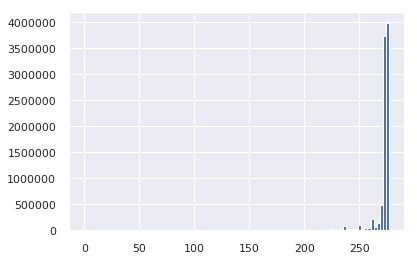

In [42]:
fe_train['AvSig2'].hist(bins=100)

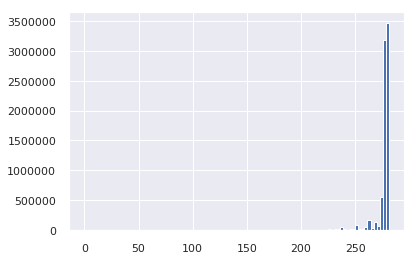

In [43]:
fe_test['AvSig2'].hist(bins=100)

In [45]:
fe_train['HasDetections'] = y
X_trn = fe_train[fe_train['AvSig2'] < 275]
X_val = fe_train[fe_train['AvSig2'] >= 275]
y_trn = X_trn['HasDetections']
y_val = X_val['HasDetections']
X_trn = X_trn.drop('HasDetections', axis=1)
X_val = X_val.drop('HasDetections', axis=1)
fe_train = fe_train.drop('HasDetections', axis=1)

In [46]:
len(X_trn)

4940736

In [47]:
len(X_val)

3980747

In [ ]:
model = train_model(X_trn, y_trn, X_val, y_val)

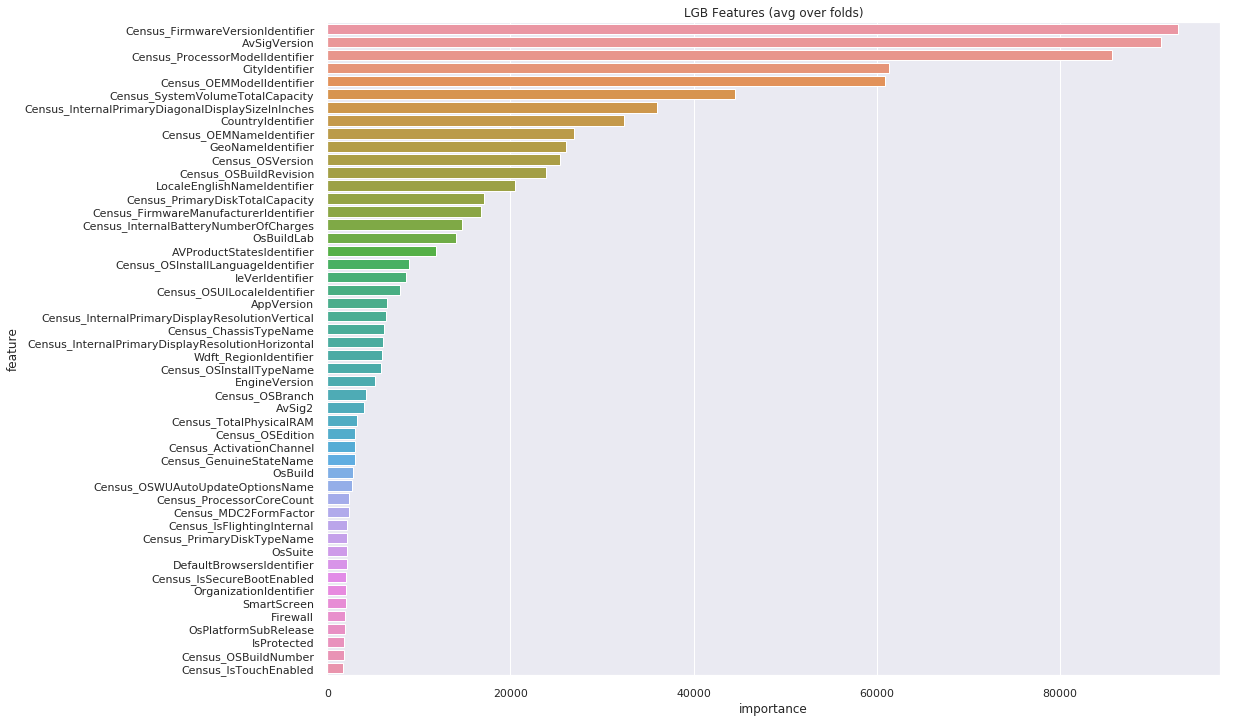

In [51]:
train_for_sub = fe_train.drop('AvSigVersion', axis=1)
test_for_sub = fe_test.drop('AvSigVersion', axis=1)
model = train_model(fe_train, y)

In [ ]:
results = test_model(model, X_test)